# Постановка 

Имеется набор интенсивностей трафика для полосы перекрестка.

Рассматриваем только те случаи когда машин больше 12

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import scipy.stats as sps

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
ticks = np.linspace(0,24*3600, 24)
labels = [str(int(_x/3600)) for _x in ticks]
margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.1,
    "right"  : 0.999,
    "top"    : 0.95 
}   
PATH = ""
curving_times = 20

BLUE = (0,0,0,0.02)
RED = (0,0,0,0.02)
GREEN = (0,0,0,0.02)


NAMES = [
"year_data_av_30_3.csv",
"year_data_av_30_4.csv",
"year_data_av_30_5.csv",
"year_data_av_31_7.csv"]

# [
# "year_data_30_3.csv",
# "year_data_30_4.csv",
# "year_data_30_5.csv"]

In [3]:
from datetime import datetime
def convert_to_unix_timestamp(date_str):
    format_str = '%Y-%m-%d %H:%M:%S'
    dt = datetime.strptime(date_str, format_str)
    return int(dt.timestamp())-1511172900+16*3600+55*60

df = pd.read_csv("year_data.csv", index_col=0)
df["dt_int"] = df["dt"].apply(convert_to_unix_timestamp)

df

,dt,usdk,zone,stat,weekday,dt_int
0,2017-11-20 16:55:00,14,1,9,0,59700
1,2017-11-20 16:55:00,14,2,2,0,59700
2,2017-11-20 17:00:00,14,1,13,0,60000
3,2017-11-20 17:00:00,14,2,5,0,60000
4,2017-11-20 17:05:00,14,1,14,0,60300
...,...,...,...,...,...,...
130358,2018-07-20 03:50:00,13,3,21,4,20921400
130359,2018-07-20 03:50:00,13,4,36,4,20921400
130360,2018-07-20 03:50:00,13,5,29,4,20921400
130361,2018-07-20 03:50:00,13,6,3,4,20921400


In [4]:
from itertools import repeat,chain


def filter (usdk, zone, df = df):
    

    # Filter rows where 'usdk' column equals 30
    usdk = df[df['usdk'] == usdk]
    usdk_zone = usdk[usdk['zone'] == zone]
    
    usdk_zone_stat = usdk_zone['stat'][1:].to_numpy() - usdk_zone['stat'][:-1].to_numpy() 
    usdk_zone_time    =  usdk_zone['dt_int'][1:].to_numpy()

    new_usdk_zone_stat = []
    new_usdk_zone_time = []
    n=0
    for car in usdk_zone_stat:
        if car:
            new_usdk_zone_stat.append(list(repeat(usdk_zone_stat[n], car)))
            new_usdk_zone_time.append(list(repeat(usdk_zone_time[n], car)))
        n+=1

    usdk_zone_stat = list(chain.from_iterable(new_usdk_zone_stat))
    usdk_zone_time = list(chain.from_iterable(new_usdk_zone_time))


    data = []
    data1 = []
    time1 = []
    n = 1
    for d in range(len(usdk_zone_time)):
        if usdk_zone_time[d] >  3600*24*n: 
            while usdk_zone_time[d] >  3600*24*n : n+=1
            new_data = {'time': np.array(time1), 'stat': np.array(data1)}
            data.append(new_data)
            
            data1 = []
            time1 = []
        
        data1.append(usdk_zone_stat[d])  
        time1.append(usdk_zone_time[d]%(3600*24*(n)) - (3600*24*(n-1)))
    return data

In [5]:
def accum(data, time = 12, hours = 4):
    data_accum = np.array([])
    for d in data:
        y = np.where( (d["time"]>=time) & (d["time"]<=time+hours*3600))
        x = d["stat"][y]
        data_accum =  np.append(data_accum, x)
    return np.array(sorted(data_accum))

In [6]:

def MakeDataSmooth(df):
        l = df["data"].to_numpy()
        l1 = l[1:]
        l2 = l[:-1]
        l[:-1] = (l1+l2)/2
        df["data"] = l

        
def Draw_my_data(ax, df , name = ""):
    

    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_xlabel("ч.", loc='right')
    ax.set_ylabel("машин", loc='top')

    ax.plot(df["time"],df["data"], color = 'red',  linewidth=1)

    ax.text(0, 10, name, style='italic', bbox={'facecolor': 'red', 'alpha': 0.2, 'pad': 0})

In [7]:
def make_kernel(data, kernel, h = 0):
    size = len(data)
    if not(h): h = hopt = pow(2.4*np.exp(4)/size, 0.2)
    
    g = lambda x_: sum([kernel((x_-x)/(h)) for x in data])/size/h

    x = np.arange(min(data), max(data), h)
    id = np.argsort(x)
    
    y = np.array([g(x_) for x_ in id])
        
        
    return x[id],y

ker_list = [
    lambda x: pow(2*np.pi,-0.5)*np.exp(-0.5*x*x),
    lambda x: 0.5*np.abs(x),
    lambda x:1 - np.abs(x),
    lambda x:0.75*(1-x*x),
    lambda x:(1+2*np.abs(x))*pow(1-np.abs(x),2),
    lambda x:1/np.pi*np.sqrt(1-x*x),
    lambda x:1/np.sqrt(2*np.pi)*np.exp(-0.5*x*x),
    lambda x:0.5*np.exp(-np.abs(x)),
    lambda x: 1/(np.pi*(1+x*x)),
    lambda x: 1/(np.exp(x)+2+np.exp(-x))
]

bins_list = lambda size:[
    int(1 + np.log2(size)),
    4*int(pow(0.75*pow(size - 1, 2), 0.2)),
    int(5*np.log10(size))
]

def draw_hist(data,ax, kernel = 0):
    #draw hist
    for bins in bins_list(len(data)):
        h, bins, pathces = ax.hist(data, bins=bins, color=BLUE, density=True)
        ax.hist(data, bins=bins, color=BLUE, density=True)
        #ax.plot(bins[:-1],h)
    # draw kernel hist
    
    x, y = make_kernel(data, ker_list[kernel])
    ax.plot(x, y, label = "ядерная оценка плотности")

In [8]:
import seaborn as sns
from matplotlib import cm
sns.set_theme(style="ticks")


def Create_Copula_Marshall_Olkin(alpha, beta):
    @np.vectorize
    def Copula_Marshall_Olkin(u,v):
        return u*v*min(pow(u,-alpha),pow(v,-beta))
    return Copula_Marshall_Olkin

@np.vectorize
def P(x,y):
  return x*y

@np.vectorize
def M(x,y):
  return min(x,y)

In [9]:
def make_rvs_CMO(U, p,  f):
    SIZE = len(U)
    u = np.random.uniform(0, 1, SIZE)
    mask = u<p[0]
    
    rvs = np.zeros(SIZE)
    f1,f2 = f
    rvs = f1.ppf(U) * mask + f2.ppf(U)* (1-mask)
    return rvs

In [10]:
def make_u_v_CMO(SIZE, alpha, beta):

    r = np.random.uniform(0, 1, SIZE)
    s = np.random.uniform(0, 1, SIZE)
    t = np.random.uniform(0, 1, SIZE)

    my_max = np.vectorize(lambda x, y: max(x, y))

    U = np.exp((1+alpha/(1-alpha)) * my_max(np.log(s), (1-alpha)/alpha*np.log(r)))
    V = np.exp((1+beta/(1-beta))*my_max(np.log(t), (1-beta)/beta*np.log(r)))

    return U, V

In [11]:
from matplotlib import rcParams
rcParams['patch.force_edgecolor'] = True

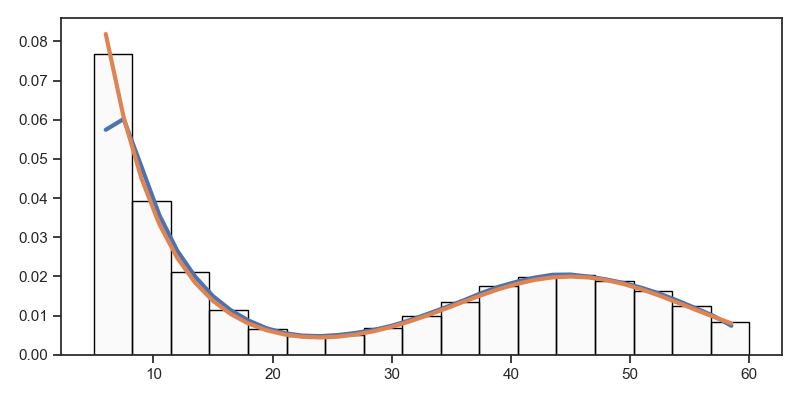

In [12]:


%matplotlib widget

SIZE = 100000

fig = plt.figure(figsize= (8,4))

margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.1,
    "right"  : 0.98,
    "top"    : 0.9  
}
fig.subplots_adjust(**margins)  


fig.set_tight_layout(0.05)

ax = fig.add_subplot( 1,1,1)


loc1 = [5, 45]
scale1 = [5, 10]
p1 = [0.5, 0.5]
f1 = sps.expon(loc=loc1[0], scale=scale1[0])
f2 = sps.norm(loc=loc1[1], scale=scale1[1])
f = [f1, f2]



def F(x): return f1.pdf(x) * p1[0] + f2.pdf(x)*p1[1]


# mixed_data = accum(filter(42,4),1,8)
mixed_data = np.append(f1.rvs(int(p1[0]*SIZE)) , f2.rvs(int(p1[1]*SIZE)))
mixed_data = mixed_data[(mixed_data<60)&(mixed_data>5)]

size = len(mixed_data)
bins =  int(1 + np.log2(size))

h, bins, pathces = ax.hist(mixed_data, bins=bins,edgecolor=(0,0,0),linewidth =1, color=BLUE, density=True)
# ax.hist(mixed_data, bins=bins, color=(0,0,0,0.2), density=True)

kernel =  lambda x: pow(2*np.pi,-0.5)*np.exp(-0.5*x*x)

h =  1.5
g = lambda x_: sum([kernel((x_-x)/(h)) for x in mixed_data])/size/h

x = np.arange(h, max(mixed_data) + h, h)
y = np.array([g(x_) for x_ in x])

mask = (x<60)&(x>5)
x = x[mask]
y= y[mask]
ax.plot(x, y,linewidth =3 )



ax.plot(x, F(x), linewidth =3)


In [13]:
loc1 = [3.8, 12]
scale1 = [4.5, 15]
p1 = [0.35, 0.65]
f1 = sps.expon(loc=loc1[0], scale=scale1[0])
f2 = sps.norm(loc=loc1[1], scale=scale1[1])
f = [f1, f2]


p2 = [0.6, 0.4]
loc2 = [3, 20]
scale2 = [8, 13]
g1 = sps.expon(loc=loc2[0], scale=scale2[0])
g2 = sps.norm(loc=loc2[1], scale=scale2[1])
g = [g1, g2]




In [14]:
# https://github.com/ethan-homan/gaussian-exponential-mixture


from gaussian_exponential_mixture import GaussianExponentialMixture



In [15]:

# mixture = GaussianExponentialMixture(data = mixed_data,max_iterations = 20000, convergence_tolerance = 0.001)
# mixture.fit()
# beta, mu, sigma, p =  mixture.parameters.beta,mixture.parameters.mu, mixture.parameters.sigma, mixture.parameters.proportion
# beta, mu, sigma, p

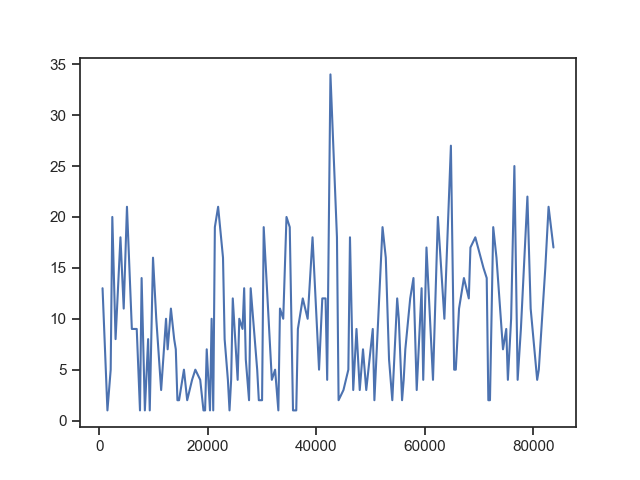

In [53]:
data = filter(30,5)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(data[1]['time'][:-50], data[1]['stat'][:-50])

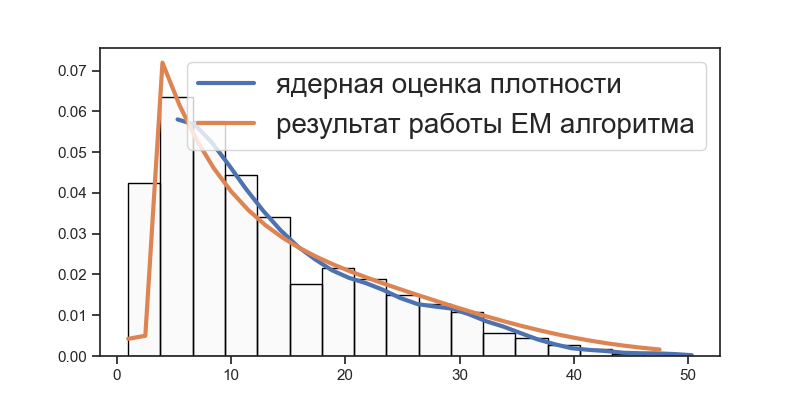

In [16]:
fig = plt.figure(figsize= (8,4))

p2 = [0.6, 0.4]
loc2 = [3, 20]
scale2 = [8, 13]
g1 = sps.expon(loc=loc2[0], scale=scale2[0])
g2 = sps.norm(loc=loc2[1], scale=scale2[1])
g = [g1, g2]


def G(x): return g1.pdf(x) * p2[0] + g2.pdf(x)*p2[1]

ax2 = fig.add_subplot( 1,1,1)
mixed_data2 = accum(filter(30,5),10,24)
mixed_data2 = mixed_data2[mixed_data2>0]
mixed_data2 = mixed_data2[mixed_data2<50]

size = len(mixed_data2)

bins =  int(1 + np.log2(size))



h, bins, pathces = ax2.hist(mixed_data2, bins=bins,edgecolor=(0,0,0),linewidth =1, color=BLUE, density=True)
# ax.hist(mixed_data, bins=bins, color=(0,0,0,0.2), density=True)

kernel =  lambda x: pow(2*np.pi,-0.5)*np.exp(-0.5*x*x)

h =  1.5
g = lambda x_: sum([kernel((x_-x)/(h)) for x in mixed_data2])/size/h
id = np.argsort(x)

x = np.arange(bins[1]+h, max(mixed_data2) + h, h)
y = np.array([g(x_) for x_ in x])

ax2.plot(x, y,linewidth =3, label = "ядерная оценка плотности" )



x = np.arange(mixed_data2.min(), mixed_data2.max(),h)
theta = -0.0
ax2.plot(x, g1.pdf(x) * (p2[0]-theta) + g2.pdf(x)*(p2[1]+theta), linewidth =3,label = "результат работы EM алгоритма")




ax2.legend(fontsize = 20)

In [17]:

# mixture = GaussianExponentialMixture(data = mixed_data2,max_iterations = 20000, convergence_tolerance = 0.001)
# mixture.fit()


In [18]:
# beta, mu, sigma, p =  mixture.parameters.beta,mixture.parameters.mu, mixture.parameters.sigma, mixture.parameters.proportion
# beta, mu, sigma, p

In [19]:
alpha = 0.95
beta = 0.25

U,V = make_u_v_CMO(100000,alpha,beta)


loc1 = [5, 45]
scale1 = [5, 10]
p1 = [0.5, 0.5]
f1 = sps.expon(loc=loc1[0], scale=scale1[0])
f2 = sps.norm(loc=loc1[1], scale=scale1[1])
f = [f1, f2]



p2 = [0.6, 0.4]
loc2 = [3, 20]
scale2 = [8, 13]
g1 = sps.expon(loc=loc2[0], scale=scale2[0])
g2 = sps.norm(loc=loc2[1], scale=scale2[1])
g = [g1, g2]




rvs_1,rvs_2 = np.array([]),np.array([])
rvs_1 = np.append(rvs_1,make_rvs_CMO(U, p1, f)) 
rvs_2 = np.append(rvs_2,make_rvs_CMO(V, p2, g)) 


rvs_1[rvs_1<0]=5
rvs_2[rvs_2<0]=0

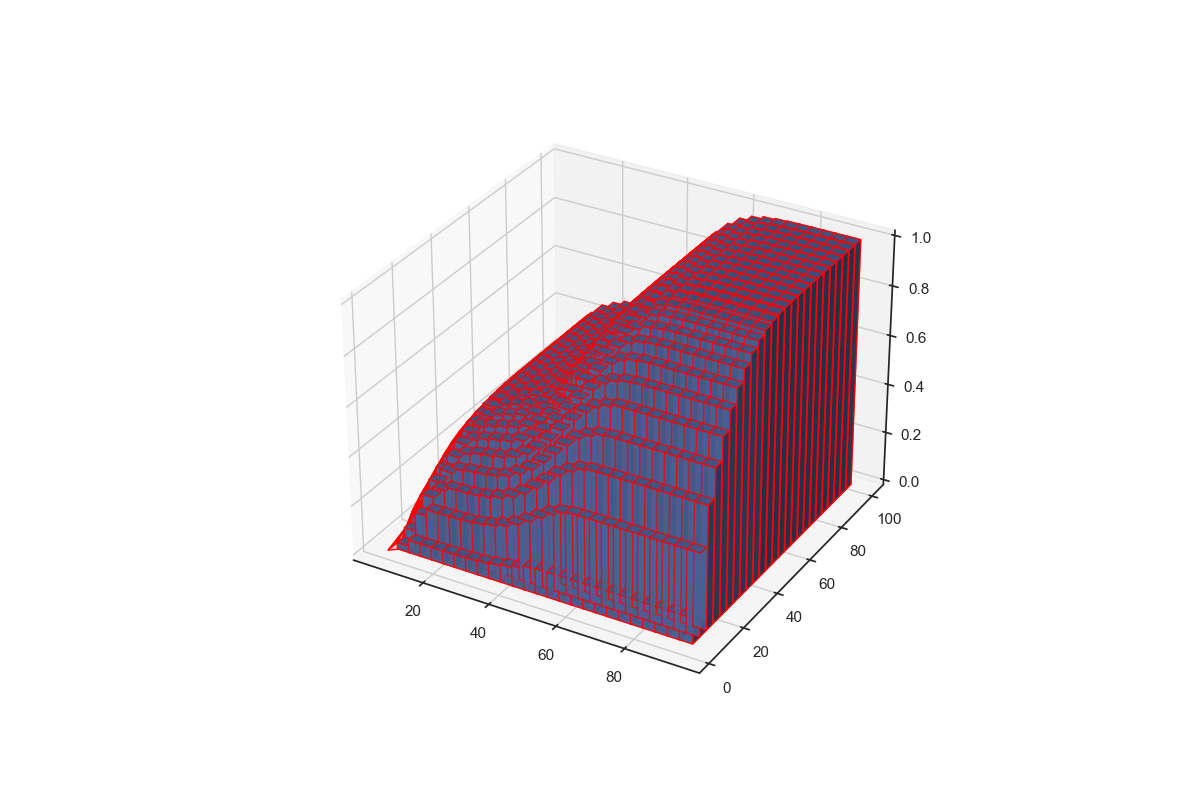

In [20]:

fig = plt.figure(figsize=(12, 8))
plt.tight_layout(pad=1, w_pad=5, h_pad=1.0)

ax = fig.add_subplot(111, projection='3d')

# %%%%%%%%%%%%%%%%%%%
H, xed, yed = np.histogram2d(rvs_1, rvs_2, (25, 25), density=False)

bar_w = (-xed[0]+xed[1]) / 2
bar_l = (-yed[0]+yed[1]) / 2


S = bar_w*bar_l
# Compute the cumulative sum along both dimensions
cumulative_counts1 = np.cumsum(np.cumsum(H, axis=0), axis=1).T
my_min = np.vectorize(lambda x, y: min(x, y))
    
# Normalize the cumulative counts to form a CDF
CH1 = cumulative_counts1 / cumulative_counts1[-1, -1]

CH = CH1
x = (xed[:-1]+xed[1:])/2
y = (yed[:-1]+yed[1:])/2
x, y = np.meshgrid(x, y)
ax.bar3d(x.ravel() + bar_w, y.ravel() + bar_l,   0, 2* bar_l, 2* bar_w, CH.ravel(),  shade = True, alpha = 0.8, edgecolor=(1,0,0,0.05))

# ax.plot_trisurf(x.ravel(), y.ravel(),  CH.T.ravel())



# U03 = pow(F(x), 0.3)
# V02 = pow(G(y), 0.2)
# mask = U03 >= V02
# С1 = (1-0.2)/U03*mask + (1-mask)*(1 - 0.3)/V02


CMO = Create_Copula_Marshall_Olkin(alpha, beta)
# C1 = (1-beta)/U03*mask + (1-mask)*(1 - alpha)/V02
def F(x): return f1.cdf(x) * p1[0] + f2.cdf(x)*p1[1]

def G(x): return g1.cdf(x) * p2[0] + g2.cdf(x)*p2[1]


C1 = CMO(F(x),G(y))
ax.plot_trisurf(x.ravel(), y.ravel(), C1.ravel(),                 color=(1, 0, 0, 0.2),  edgecolor=(1, 0, 0, 1))

In [21]:
max(abs(C1.ravel() - CH.ravel()))

0.14479434692392415

In [22]:
len(accum(filter(30,3),0,1))

2558

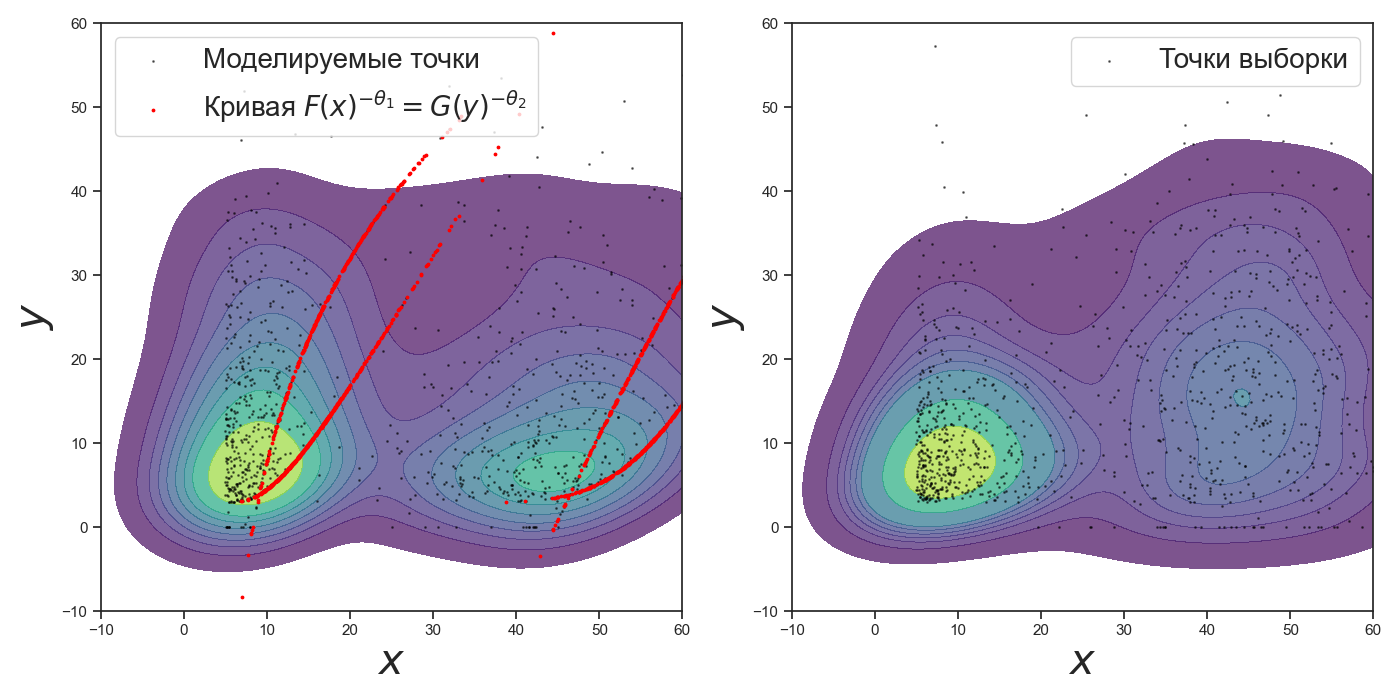

In [40]:
import seaborn as sns

# Генерация данных
np.random.seed(42)
size = 1000

x = rvs_1[:size]
y = rvs_2[:size]

x[x<0] = 0
y[y<0] = 0


fig = plt.figure(figsize=(14, 7))

margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.1,
    "right"  : 0.98,
    "top"    : 0.9  
}
fig.subplots_adjust(**margins)  


fig.set_tight_layout(0.05)



ax = fig.add_subplot(1,2,1)

# Построение диаграммы рассеяния с контурными линиями плотности
sns.kdeplot(x=x, y=y,ax=ax, fill=True, cmap="viridis", levels=10, alpha=0.7)  # KDE-фон
ax.scatter(x, y, s=1, color="black", alpha=0.5, label="Моделируемые точки")  # Точки поверх фона
ax.set_xlim((-10,60))
ax.set_ylim((-10,60))


U = np.random.uniform(0, 1, 10000000)
V = np.random.uniform(0, 1, 10000000)
U1 = pow(U , -alpha )
V1 = pow(V , -beta )
gate = 0.0001
mask = (U1< V1 +gate) & ((U1+gate> V1))
U  = U[mask]
V  = V[mask]
x = make_rvs_CMO(U, p1, f)
y = make_rvs_CMO(V, p2, g)

ax.scatter(x, y, color =(1,0,0), s = 3, label = r"Кривая $F(x)^{-\theta_1} = G(y)^{-\theta_2}$")
ax.set_xlabel(r"$x$", fontsize = 30)
ax.set_ylabel(r"$y$", fontsize = 30)
ax.legend(fontsize = 20)


ax2 = fig.add_subplot(1,2,2)
x = np.append(f1.rvs(int(p1[0]*size)) , f2.rvs(int(p1[1]*size)))
y = np.append(g1.rvs(int(p2[0]*size)) , g2.rvs(int(p2[1]*size)))

x[x<0] = 0
y[y<0] = 0
# x = accum(filter(30,4),0,24)
# y = accum(filter(30,5),0,24)
# rows, = min(x.shape, y.shape)
# y = y[:rows]
# x = x[:rows]
# ax2.set_xlim((-10,40))
# ax2.set_ylim((-10,40))

# Построение диаграммы рассеяния с контурными линиями плотности
sns.kdeplot(x=x, y=y,ax=ax2, fill=True, cmap="viridis", levels=10, alpha=0.7)  # KDE-фон
ax2.scatter(x, y, s=1, color="black", alpha=0.5, label="Точки выборки")  # Точки поверх фона
ax2.set_xlim((-10,60))
ax2.set_ylim((-10,60))
ax2.set_xlabel(r"$x$", fontsize = 30)
ax2.set_ylabel(r"$y$", fontsize = 30)
ax2.legend(fontsize = 20)

fig.savefig("scatterplot.png", dpi =300)

-0.7

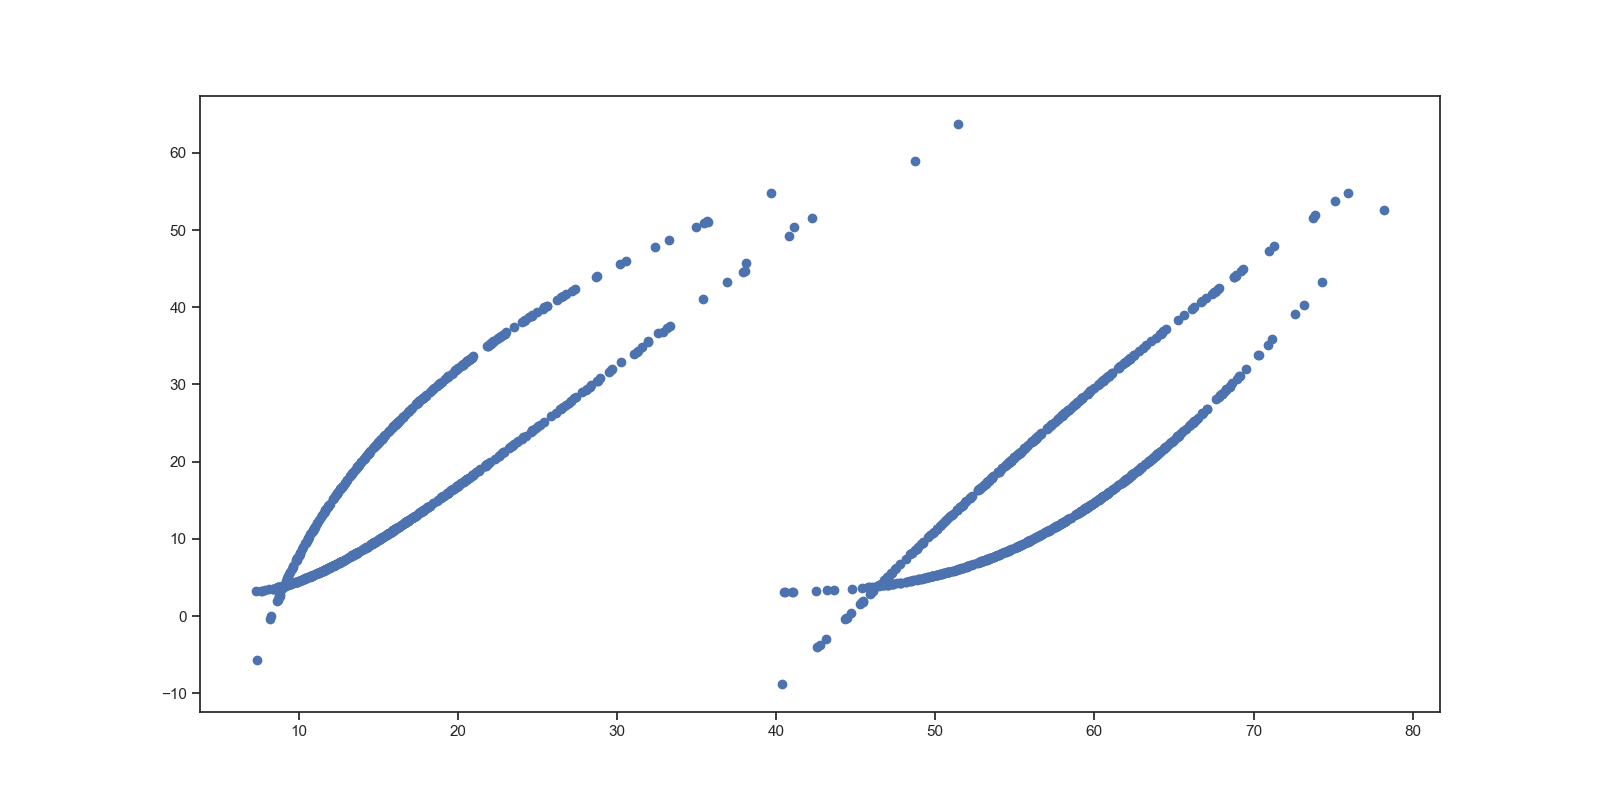

In [24]:

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1,1,1)

U = np.random.uniform(0, 1, 10000000)
V = np.random.uniform(0, 1, 10000000)
U1 = pow(U , -alpha )
V1 = pow(V , -beta )
gate = 0.0001
mask = (U1< V1 +gate) & ((U1+gate> V1))
U  = U[mask]
V  = V[mask]
x = make_rvs_CMO(U, p1, f)
y = make_rvs_CMO(V, p2, g)

ax.scatter(x, y)
beta - alpha

In [25]:
mask

array([False, False, False, ..., False, False, False])

In [26]:
# U,V = make_u_v_CMO(100000,alpha,beta)

# loc1 = [0, 12]
# scale1 = [1, 5]
# p1 = [0.2, 0.8]
# f1 = sps.expon(loc=loc1[0], scale=scale1[0])
# f2 = sps.norm(loc=loc1[1], scale=scale1[1])
# f = [f1, f2]


# # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


# loc2 = [3, 20]
# scale2 = [4, 3]
# p2 = [0.3, 0.7]
# g1 = sps.expon(loc=loc2[0], scale=scale2[0])
# g2 = sps.norm(loc=loc2[1], scale=scale2[1])
# g = [g1, g2]




# rvs_1 = make_rvs_CMO(U, p1[0],loc1,scale1)
# rvs_2 = make_rvs_CMO(V, p2[0],loc2,scale2)




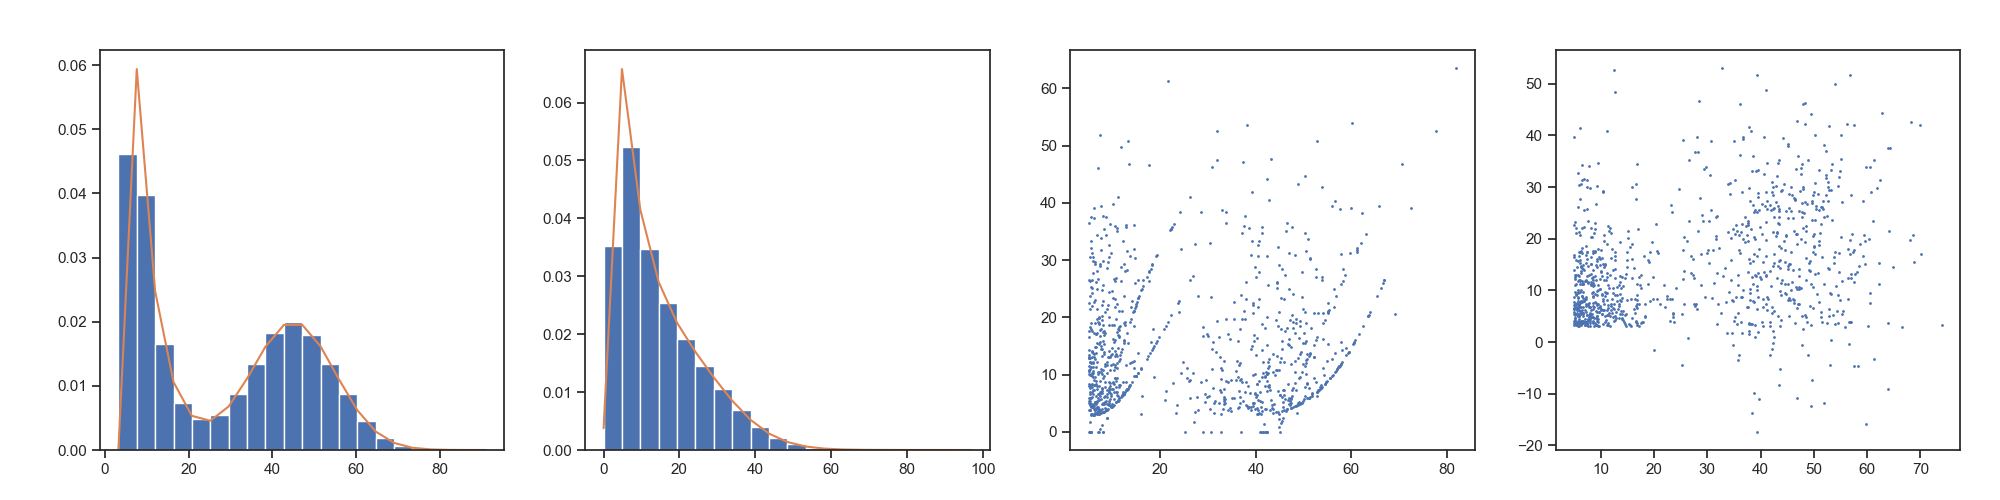

In [27]:
fig  = plt.figure(figsize=(20,5))

margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.1,
    "right"  : 0.98,
    "top"    : 0.9  
}
fig.subplots_adjust(**margins)  

ax = fig.add_subplot(141)
H, xed,bar = ax.hist(rvs_1, 20, density=True)

x = (xed[:-1]+xed[1:])/2
F2 = lambda x : f1.pdf(x) * p1[0] + f2.pdf(x)*p1[1]
ax.plot(xed, F2(xed))


ax = fig.add_subplot(142)
H, xed,bar = ax.hist(rvs_2, 20, density=True)

x = (xed[:-1]+xed[1:])/2
G2 = lambda x : g1.pdf(x) * p2[0] + g2.pdf(x)*p2[1]
ax.plot(xed, G2(xed))

size = 1000

ax = fig.add_subplot(143)
ax.scatter(rvs_1[:size],rvs_2[:size], s= 1)

x = np.append(f1.rvs(int(p1[0]*size)) , f2.rvs(int(p1[1]*size)))
y = np.append(g1.rvs(int(p2[0]*size)) , g2.rvs(int(p2[1]*size)))

ax = fig.add_subplot(144)
ax.scatter(x,y, s= 1)

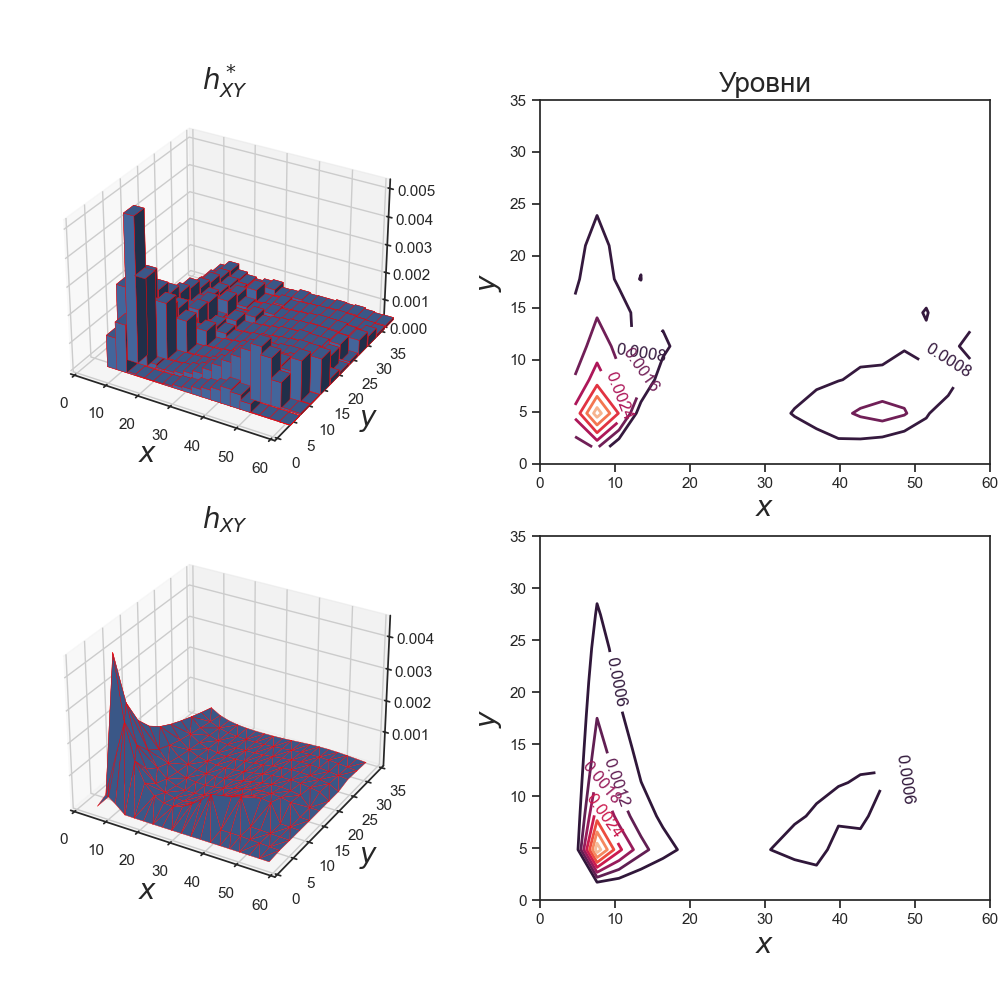

In [38]:
barsx, barsy = 30,30
H, xed, yed = np.histogram2d(rvs_1, rvs_2, (barsx, barsy),density=True)
H = H.T
bar_w = (-xed[0]+xed[1]) / 2
bar_l = (-yed[0]+yed[1]) / 2


XLIM = (0,60)
YLIM = (0,35)

# В numpy надо всегда читать документацию (так например Histogram does not follow Cartesian convention )


fig = plt.figure(figsize=(10, 10))

margins = {                                                                          
    "left"   : 0.0,
    "bottom" : 0.1,
    "right"  : 0.99,
    "top"    : 0.9  
}
fig.subplots_adjust(**margins)  



ax = fig.add_subplot(221,projection='3d')
ax.set_xlim(*XLIM)
ax.set_ylim(*YLIM)
ax.set_title(r"$h^*_{XY}$", fontsize =20)
ax.set_xlabel(r"$x$", fontsize = 20)
ax.set_ylabel(r"$y$", fontsize = 20)

x = (xed[:-1]+xed[1:])/2
y = (yed[:-1]+yed[1:])/2

x_mask = (x>XLIM[0]) & (x<XLIM[1])
y_mask = (y>YLIM[0]) & (y<YLIM[1])
x = x[x_mask]
y = y[y_mask]
H = H_new = np.array([ h[x_mask] for h in H[y_mask] ])


x,y = np.meshgrid(x,y)

# Normalize the cumulative counts to form a CDF


CH = H

ax.bar3d(x.ravel() + bar_w, y.ravel() + bar_l,   0, 2*bar_l, 2*bar_w, CH.ravel(),  shade = True, alpha = 1, edgecolor=(1,0,0), linewidth = 0.3 )


x1,y1 = x,y # np.meshgrid(np.linspace(*XLIM,mesh_space),np.linspace(*YLIM,mesh_space))


F1 = f1.cdf(x1.ravel()) * p1[0] + f2.cdf(x1.ravel())*p1[1]
G1 = g1.cdf(y1.ravel()) * p2[0] + g2.cdf(y1.ravel())*p2[1]

F2 = f1.pdf(x1.ravel()) * p1[0] + f2.pdf(x1.ravel())*p1[1]
G2 = g1.pdf(y1.ravel()) * p2[0] + g2.pdf(y1.ravel())*p2[1]
U = pow(F1,-alpha)
V = pow(G1,-beta)
mask = U <= V
C1 = ((1-alpha)*U*mask + (1-mask)*(1 - beta)*V)*F2*G2
C1 = C1.reshape(x1.shape)


# ax.bar3d(x.ravel() + bar_w, y.ravel() + bar_l,   0, 2* bar_l, 2* bar_w, H.ravel(),  shade = True, alpha = 0.8, edgecolor=(1,0,0,0.05))
# ax.plot_trisurf(x.ravel() , y.ravel() ,  H.ravel())

ax = fig.add_subplot(223,projection='3d')
ax.set_xlim(*XLIM)
ax.set_ylim(*YLIM)
ax.set_title(r"$h_{XY}$", fontsize =20)
ax.set_xlabel(r"$x$", fontsize = 20)
ax.set_ylabel(r"$y$", fontsize = 20)


ax.plot_trisurf(x1.ravel(), y1.ravel(),C1.ravel(),  edgecolor=(1,0,0), linewidth = 0.3 )



ax = fig.add_subplot(222)
ax.set_xlim(*XLIM)
ax.set_ylim(*YLIM)
ax.set_title(r"Уровни", fontsize =20)
ax.set_xlabel(r"$x$", fontsize = 20)
ax.set_ylabel(r"$y$", fontsize = 20)
CS = ax.contour(x, y, CH, linewidths = 2)
ax.clabel(CS,CS.levels)


ax = fig.add_subplot(224)
ax.set_xlim(*XLIM)
ax.set_ylim(*YLIM)
ax.set_xlabel(r"$x$", fontsize = 20)
ax.set_ylabel(r"$y$", fontsize = 20)
CS = ax.contour(x1, y1, C1, linewidths = 2)
ax.clabel(CS,CS.levels)


fig.savefig("EM_revive_density_function.png",dpi =300)
plt.show()


In [29]:
F = f1.pdf(x) * p1[0] + f2.pdf(x)*p1[1]
F.shape

(11, 19)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


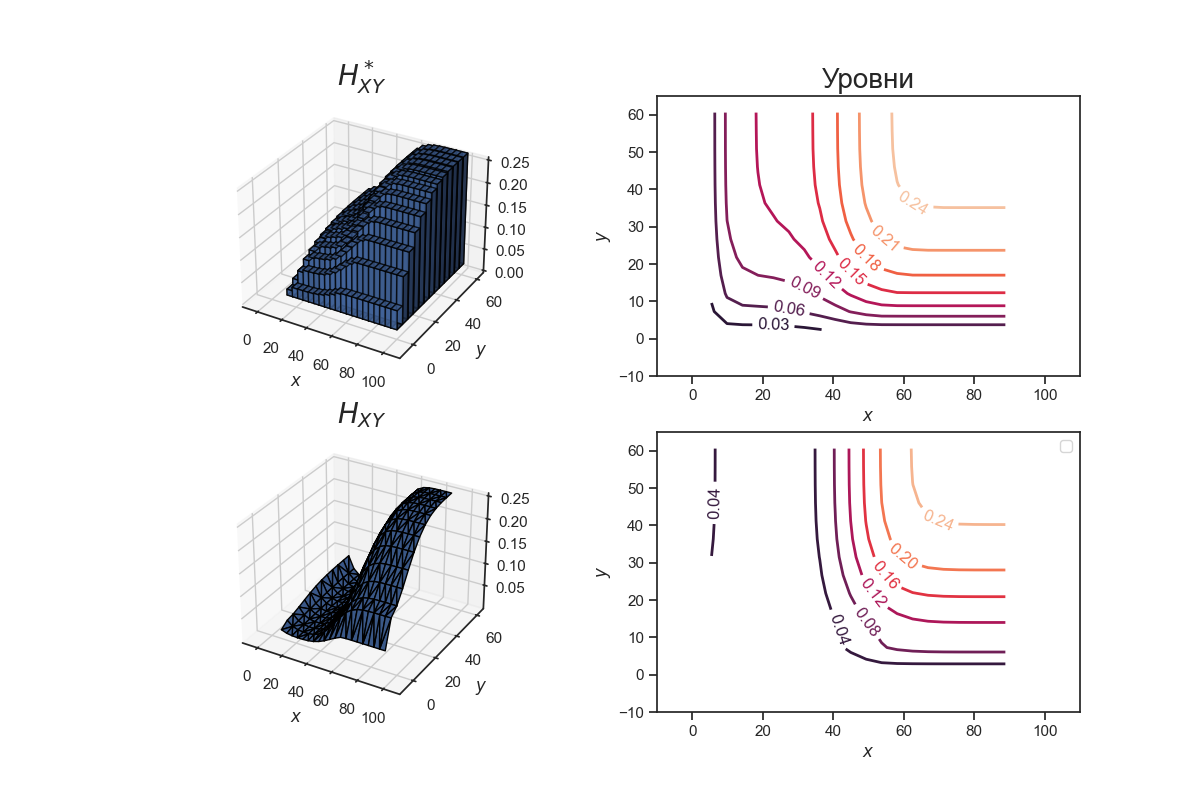

In [30]:
barsx, barsy = 20,20
H, xed, yed = np.histogram2d(rvs_1, rvs_2, (barsx, barsy),density=True)
bar_w = (-xed[0]+xed[1]) / 2
bar_l = (-yed[0]+yed[1]) / 2
H_ = H

S = bar_w*bar_l

XLIM = (-10,110)
YLIM = (-10,65)

# В numpy надо всегда читать документацию (так например Histogram does not follow Cartesian convention )
H = H.T#/S


fig = plt.figure(figsize=(12, 8))
plt.tight_layout(pad=1, w_pad=5, h_pad=1.0)

ax = fig.add_subplot(221,projection='3d')
ax.set_xlim(*XLIM)
ax.set_ylim(*YLIM)
ax.set_title(r"$H^*_{XY}$", fontsize =20)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

x = (xed[:-1]+xed[1:])/2

y = (yed[:-1]+yed[1:])/2

x_mask = (x>XLIM[0]) & (x<XLIM[1])
y_mask = (y>YLIM[0]) & (y<YLIM[1])

x = x[x_mask]
y = y[y_mask]
H = H_new = np.array([ h[x_mask] for h in H[y_mask] ])
x_,y_ = x,y
x,y = np.meshgrid(x,y)


# Compute the cumulative sum along both dimensions
cumulative_counts1 = np.cumsum(np.cumsum(H, axis=0), axis=1).T
my_min = np.vectorize(lambda x, y: min(x, y))

#





F =  lambda x: f1.pdf(x) *p1[0] + f2.cdf(x)*p1[1]
G =  lambda x: g1.pdf(x) *p2[0] + g2.cdf(x)*p2[1] 

CMO = Create_Copula_Marshall_Olkin(alpha, beta)
C1 = CMO(F(x),G(y))


# Normalize the cumulative counts to form a CDF
CH1 = cumulative_counts1 / cumulative_counts1[-1, -1]  * C1[-1,-1]

CH = CH1.T
ax.bar3d(x.ravel() + bar_w, y.ravel() + bar_l,   0, 2* bar_l, 2* bar_w, CH.ravel(),  shade = True, alpha = 0.8, edgecolor=(0,0,0,1))

# ax.bar3d(x.ravel() + bar_w, y.ravel() + bar_l,   0, 2* bar_l, 2* bar_w, H.ravel(),  shade = True, alpha = 0.8, edgecolor=(1,0,0,0.05))
# ax.plot_trisurf(x.ravel() , y.ravel() ,  H.ravel())

ax = fig.add_subplot(223,projection='3d')
ax.set_xlim(*XLIM)
ax.set_ylim(*YLIM)
ax.set_title(r"$H_{XY}$", fontsize =20)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")


ax.plot_trisurf(x.ravel(), y.ravel(),C1.ravel(),  edgecolor=(0,0,0,1))



ax = fig.add_subplot(222)
ax.set_xlim(*XLIM)
ax.set_ylim(*YLIM)
ax.set_title(r"Уровни", fontsize =20)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
CS = ax.contour(x, y, CH, linewidths = 2)
ax.clabel(CS,CS.levels)


ax = fig.add_subplot(224)
ax.set_xlim(*XLIM)
ax.set_ylim(*YLIM)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
CS = ax.contour(x,y,C1, linewidths = 2)
ax.clabel(CS,CS.levels)

ax.legend()


plt.show()


In [31]:
from scipy.integrate import dblquad
H=CH
def edf(v,u):
    
    ids = (X<=u)
    idx = 0 if not(len(ids)) else np.argmax(1-ids)-1
    
    ids = (Y<=v)
    idy = 0 if not(len(ids)) else np.argmax(1-ids)-1

    
    return H[idx,idy]


X,Y = x_,y_ 
S = (max(xed) - min(xed)) / barsx * (max(yed) - min(yed)) / barsy
CDF = np.zeros_like(H)
# Calculate CDF values using double integratio


    

In [32]:
np.sum(H[:i+1, :j+1])

NameError: name 'i' is not defined

In [ ]:
# Создание фигуры
fig = plt.figure()

# Добавление 3D-осей к фигуре
ax = fig.add_subplot(111, projection='3d')

cdf = np.zeros_like(H)

for i in range(H.shape[0]):
    for j in range(H.shape[1]):
        bufferH= H[:i+1, :j+1].ravel()
        buffer = bufferH.sum()* S
        cdf[i, j] += buffer

# Нормализуем CDF так, чтобы она была от 0 до 1
cdf = cdf / cdf[-1, -1]
        
ax.plot_trisurf(x.ravel(), y.ravel(),cdf.ravel(),  edgecolor=(1,0,0,1))
ax.set_xlim(*XLIM)
ax.set_ylim(*YLIM)

In [ ]:
f = lambda x: f1.cdf(x) *0.7 + f2.cdf(x)*0.3

pair = np.array(np.meshgrid(rvs_1, rvs_2)).reshape(2,-1)


func = lambda x: CMO(f(x[0]), f(x[1]))

C = func(pair)


# fig = plt.figure()
# ax = fig.add_subplot(122, projection = "3d")
# ax.scatter(pair[0],pair[1],C.ravel(),   cmap = cm.jet, )

In [ ]:
# Создание фигуры
fig = plt.figure()

# Добавление 3D-осей к фигуре
ax = fig.add_subplot(111, projection='3d')

f = lambda x: f1.cdf(x) *0.7 + f2.cdf(x)*0.3
func = lambda x : CMO(f(x[0]), f(x[1]))

pair = np.array([x,y]).reshape(2,-1)
 

ax.plot_trisurf(x.ravel(), y.ravel(), func(pair),  edgecolor=(1,0,0,1))
ax.set_xlim(*XLIM)
ax.set_ylim(*YLIM)

In [ ]:
pair = np.array(np.meshgrid(rvs_1, rvs_2)).reshape(2,-1).T


f = lambda x: f1.cdf(x) *0.7 + f2.cdf(x)*0.3

func = lambda x : CMO(f(x[0]), f(x[1]))


In [ ]:

rvs = sps.norm(0,1).rvs(100)

ks_stat, p_value = sps.kstest(pair,  func )
ks_stat, p_value
    

In [ ]:
from scipy.integrate import dblquad


# Create meshgrid for x and y
pairs = np.array(np.meshgrid(rvs_1, rvs_2))
pairs = (pairs.T)
print(pairs.shape)

CMO = Create_Copula_Marshall_Olkin(alpha, beta)
C_new = lambda x: CMO(F(x[0]), G(x[1]))
C4 = np.array( [[C_new(x) for x in pairsx] for pairsx in pairs])

# Initialize CDF array
CDF = np.zeros_like(C4)

print(len(rvs_1))
# Calculate CDF values using double integration
for i in range(len(rvs_1)-1):
    for j in range(len(rvs_2)-1):
        # Define the integration limits for x and y
        xmin = 0 if i == 0 else rvs_1[i-1]
        xmax = rvs_1[i]
        ymin = 0 if j == 0 else rvs_2[j-1]
        ymax = rvs_2[j]

        # Define the integrand function
        # Perform double integration to get CDF value

        
        integrand = lambda v, u: CMO(F(u), G(v))
        
        CDF[i, j], _ = dblquad(integrand, xmin, xmax, lambda u: ymin, lambda u: ymax)
CDF= CDF.reshape(-1)
CDF.shape

In [ ]:
pairs = pairs.reshape(-1,2)
pairs.shape
l = pairs

In [ ]:
def kolmogorov_smirnov_bolshev(data, dist=norm):
    # Эмпирическая функция распределения
    data_sorted, edf = empirical_cdf(data)
    
    # Теоретическая функция распределения
    cdf_theoretical = dist.cdf(data_sorted)
    
    # Статистика Колмогорова
    D_n = np.max(np.abs(edf - cdf_theoretical))
    
    # Поправка Большева
    n = len(data)
    D_bolshev = D_n * np.sqrt(n) + (0.12 + 0.11 / np.sqrt(n)) / np.sqrt(n)
    
    return D_bolshev

In [ ]:
D = np.max(np.abs(H.ravel() - C1.ravel()))
D

In [ ]:
, H.size, C1.size

F = C1.ravel()
#%%%%%%%%%%%%% КРИТЕРИЙ КОЛМОГОРОВА СМИРНОВА %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

n = F.size

i_n = np.linspace(1,n+1,n)/n
i_n_ = np.linspace(0,n,n)/n

Dn_plus = max(i_n - C1)



In [ ]:
fig, ax = plt.subplots()
ax.hist(rvs_1,color = (1,0,0), density = True)

In [ ]:

fig = plt.figure(figsize= (10,10))

margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.1,
    "right"  : 0.98,
    "top"    : 0.9  
}
fig.subplots_adjust(**margins)  




In [ ]:

def MAKE_EM(a, x, steps, ax):
        

    def Estep(X,p,psi):
        N = X.size
        K = p.size

        G =np.zeros((K,N))
        for j in range(N):
            psij = psi(X[j])
            dotppsi = np.dot(p,psij)
            G[:,j] = p*psij/(dotppsi)
        return G

    def Mstep(G,X):
        K,N = G.shape
        n = np.array([sum(G[i,:]) for i in range(K)])
        p = n/N
        a = np.array([np.dot(G[i,:],X) for i in range(K)])/n
        sigma = np.array([np.dot(G[i,:],(X-a[i])*(X-a[i])) for i in range(K)])/n
        return p,a,sigma
    def Draw(A,Sigma,p):
        K = len(A)
        X = np.linspace(0,30,200)

        draw_hist(x,ax)
        for k in range(K):
            a = A[k]
            sigma = Sigma[k]
            ax.plot(X,sps.norm.pdf(X,a,sigma)*p[k], label = fr"$a = {a:.1f}, \sigma^2 = {sigma:.1f}, p = {p[k]:.1f}$",color = (0,1,0))

        
        ax.legend()
        
        
    a1,a2 = a
    sigma1 = 1
    sigma2 = 1
    psi = lambda x: np.array([ sps.norm.pdf(x,a1,sigma1), sps.norm.pdf(x,a2,sigma2)])

    p = np.array([0.6,0.4])
    T = steps
    for m in range(T):
        G = Estep(x,p,psi)
        p,a,sigma = Mstep(G,x)

    print(p)
    print(a)
    print(np.sqrt(sigma))

    sigma = np.sqrt(sigma)

    Draw(a,np.sqrt(sigma),p)
    
    disA=lambda x: np.exp(-0.5*(x-a[0])**2 / sigma[0]**2.) / (sigma[0]*np.sqrt(2.0 * np.pi))
    disB=lambda x: np.exp(-0.5*(x-a[1])**2 / sigma[1]**2.) / (sigma[1]*np.sqrt(2.0 * np.pi))
    psi = lambda x: p[0]*disA(x)+p[1]*disB(x) 


    def entropy_single(p):
        return np.sum(p * np.log(p), axis=0)

    def KLD(p,q):
        """Дивергенция Кульбака-Лейблера"""
        if  np.count_nonzero(q) != len(p):
            return None
        if p is None:
            return np.sum(entropy_single(q), axis=0)
        if q is None:
            return np.sum(entropy_single(p), axis=0)
        return sum(np.multiply(p,np.log(p) - np.log(q)))


    #строим эмпирическую функцию распределения F*
    # x_, y_ = make_kernel(mixed_data, lambda x: pow(2*np.pi,-0.5)*np.exp(-0.5*x*x), 1.5)
    # q = psi(x_)
    # p = y


    # kld_val = KLD(p,q)
    # ish_val = 0.5 * (kld_val + KLD(q, p))

    # return  f"KLD  = {kld_val:.2f},   IShD = {ish_val:.2f} ",psi

In [ ]:
STEPS = 20
fig = plt.figure(figsize= (10,10))

margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.1,
    "right"  : 0.98,
    "top"    : 0.9  
}
fig.subplots_adjust(**margins)  
k = 0



ax = fig.add_subplot(1,1,1)
kld_str = MAKE_EM([5,45], mixed_data, STEPS,ax )

In [ ]:

mix = GaussianExponentialMixture(mixed_data,max_iterations=30, convergence_tolerance=0.01, distribution_fix = False)
mix.fit()

print(mix.parameters)
fig = plt.figure(figsize= (10,10))

margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.1,
    "right"  : 0.98,
    "top"    : 0.9  
}
fig.subplots_adjust(**margins)  

ax = fig.add_subplot( 1,1,1)
ax.plot(x, mix.pdf(x))
ax.hist(mixed_data, density=True, bins=50)

In [ ]:
%matplotlib widget
fig = plt.figure(figsize= (10,10))

margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.1,
    "right"  : 0.98,
    "top"    : 0.9  
}
fig.subplots_adjust(**margins)  

data = []

for k in range(len(NAMES)):

    df1 = pd.read_csv(PATH+NAMES[k], header= None, delimiter=r"\s+", names=["time", "data"])
    # filter = df["data"]>13
    # df = df[filter]
    x =df1["data"].to_numpy() 
    x[x>24] = x[x>24] 
    x.sort()
    ax = fig.add_subplot( 2 , 2, k  + 1)
    draw_hist(x,ax,0)
    ax.set_title(NAMES[k][:-4])
fig.savefig(PATH + "yad_oc_dens.png",dpi = 100)

# Дисперсионный анализ


Разобьем этот набор на 2 части соотв. времени года и посмотрим влияет ли время года (наличие снега) на интенсивность машин
 
Считаем что снег выпал с **2017-11-20 16:55:00** и отсчет ведется начиная с этого момента в секундах




## Предположения классической схемы однофакторного дисперсионного анализа относительно выборочных данных
  * данные внутри групп получены из нормального распределения;
  * внутригрупповые дисперсии данных одинаковы;
  * данные независимы.

Пусть модель измерений имеет следующий вид: $$x_{i,j}=\mu_i+e_{i,j}$$
где $x_{i,j}$ – $i$-ое измерение в $j$-й группе; $\mu_i,\;i=1, \cdots, k$ – внутригрупповые средние; $e_{i,j}$ – ошибки.

Данную модель можно переписать следующим образом:
$$x_{i,j}-\mu=\mu_i-\mu +e_{i,j}$$
В условиях нулевой гипотезы $(\mu_j=\mu)$ последняя эквивалентна следующему:
$$\sum\limits_{i,j} (x_{i,j}-\mu)^2 = \sum\limits_{i,j}(\mu_i-\mu)^2 + \sum\limits_{i,j}(e_{i,j})^2,$$
или
$$SS_{total}=SS_{between}+SS_{within}.$$
Также в условиях предположений о нормальности можно показать, что $\displaystyle \frac{SS_{total}}{n-1}$ имеет $\chi^2$ распределение с $n-1$ степенями свободы; аналогично:
$\displaystyle \frac{SS_{between}}{m-1}$ имеет $\chi^2$ распределение с $m-1$ степенями свободы;
$\displaystyle \frac{SS_{within}}{n-m}$ имеет $\chi^2$ распределение с $n-m$ степенями свободы.

**Это позволяет сформулировать критерий Фишера**:
$$\frac{SS_{total}}{SS_{within}}=\frac{SS_{between}}{SS_{within}}+1$$
или в условиях нулевой гипотезы $SS_{between} ≡ 0$, получим, что
$$F(m-1, n-m)=\frac{SS_{between}/(m-1)}{SS_{within}/(n-m)}$$
имеет распределение Фишера с $m-1$ и $n-m$ степенями свободы, что можно использовать для проверки значимости гипотезы.

In [ ]:
winter_beg = 0
winter_end = 4*24*3600


df =  pd.read_csv(PATH+NAMES[0], header= None, delimiter=r"\s+", names=["time", "data"])

#MakeDataSmooth(df)



In [ ]:

def MAKE_EM(a, x, steps, ax):
        

    def Estep(X,p,psi):
        N = X.size
        K = p.size

        G =np.zeros((K,N))
        for j in range(N):
            psij = psi(X[j])
            dotppsi = np.dot(p,psij)
            G[:,j] = p*psij/(dotppsi)
        return G

    def Mstep(G,X):
        K,N = G.shape
        n = np.array([sum(G[i,:]) for i in range(K)])
        p = n/N
        a = np.array([np.dot(G[i,:],X) for i in range(K)])/n
        sigma = np.array([np.dot(G[i,:],(X-a[i])*(X-a[i])) for i in range(K)])/n
        return p,a,sigma
    def Draw(A,Sigma,p):
        K = len(A)
        X = np.linspace(0,30,200)

        draw_hist(x,ax)
        for k in range(K):
            a = A[k]
            sigma = Sigma[k]
            ax.plot(X,sps.norm.pdf(X,a,sigma)*p[k], label = fr"$a = {a:.1f}, \sigma^2 = {sigma:.1f}, p = {p[k]:.1f}$",color = (0,1,0))

        
        ax.legend()
        
        
    a1,a2,a3 = a
    sigma1 = 1
    sigma2 = 1
    sigma3 = 1
    psi = lambda x: np.array([ sps.norm.pdf(x,a1,sigma1), sps.norm.pdf(x,a2,sigma2), sps.norm.pdf(x,a3,sigma3)])

    p = np.array([0.1,0.1,0.8])
    T = steps
    for m in range(T):
        G = Estep(x,p,psi)
        p,a,sigma = Mstep(G,x)

    print(p)
    print(a)
    print(np.sqrt(sigma))

    sigma = np.sqrt(sigma)

    Draw(a,np.sqrt(sigma),p)
    
    disA=lambda x: np.exp(-0.5*(x-a[0])**2 / sigma[0]**2.) / (sigma[0]*np.sqrt(2.0 * np.pi))
    disB=lambda x: np.exp(-0.5*(x-a[1])**2 / sigma[1]**2.) / (sigma[1]*np.sqrt(2.0 * np.pi))
    disC=lambda x: np.exp(-0.5*(x-a[2])**2 / sigma[2]**2.) / (sigma[2]*np.sqrt(2.0 * np.pi))
    psi = lambda x: p[0]*disA(x)+p[1]*disB(x) + p[2]*disC(x)


    def entropy_single(p):
        return np.sum(p * np.log(p), axis=0)

    def KLD(p,q):
        """Дивергенция Кульбака-Лейблера"""
        if  np.count_nonzero(q) != len(p):
            return None
        if p is None:
            return np.sum(entropy_single(q), axis=0)
        if q is None:
            return np.sum(entropy_single(p), axis=0)
        return sum(np.multiply(p,np.log(p) - np.log(q)))


    # строим эмпирическую функцию распределения F*
    x, y = make_kernel(x, lambda x: pow(2*np.pi,-0.5)*np.exp(-0.5*x*x))
    q = psi(x)
    p = y


    kld_val = KLD(p,q)
    ish_val = 0.5 * (kld_val + KLD(q, p))

    return  f"KLD  = {kld_val:.2f},   IShD = {ish_val:.2f} ",psi

In [ ]:
STEPS = 10
fig = plt.figure(figsize= (10,10))

margins = {                                                                          
    "left"   : 0.05,
    "bottom" : 0.1,
    "right"  : 0.98,
    "top"    : 0.9  
}
fig.subplots_adjust(**margins)  
k = 0

A = [
    [0, 15, 30],
    [0, 22, 30],
    [2.5, 25. ,30],
    [0, 12, 18]
]

data = []
for name in NAMES:
    df =  pd.read_csv(PATH+name, header= None, delimiter=r"\s+", names=["time", "data"])
    
    x =df["data"].to_numpy()
    a= A[k]
    ax = fig.add_subplot( 2 , 2, k  :=  k + 1)
    kld_str = MAKE_EM(a, x, STEPS,ax )
    ax.set_title(name + "\n" + kld_str[0])
    data.append(kld_str[1])
fig.savefig(PATH + "yad_oc_dens.png",dpi = 100)

In [ ]:
import seaborn as sns

sns.set_theme(style="ticks")


def Create_Copula_Marshall_Olkin(alpha, beta):
    @np.vectorize
    def Copula_Marshall_Olkin(u,v):
        return u*v*min(pow(u,-alpha),pow(v,-beta))
    return Copula_Marshall_Olkin

@np.vectorize
def P(x,y):
  return x*y

@np.vectorize
def M(x,y):
  return min(x,y)

In [ ]:
alpha = 1/2
beta = 1/4

X = np.linspace(0, 40, 30)
Y = np.linspace(0, 40, 30)
X, Y = np.meshgrid(X, Y)
X = X.ravel()
Y = Y.ravel()

F = data[1]
G = data[3]
CMO = Create_Copula_Marshall_Olkin(alpha, beta)

C1 = CMO(F(X), G(Y))

In [ ]:
from matplotlib import cm 

In [ ]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection = "3d")
ax.plot_trisurf(X,Y,C1, cmap = cm.jet, )
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$Y$")
ax.set_zlabel(r"$C(F(X),G(Y))$")
fig.savefig("C://Users//Stationary_PC//Documents//tex//SUITMM 2024//CFxGy.png", dpi =300)

In [ ]:
from numpy import exp

size = 10000

L1 = 1
L2 = 3
L12 = 1
alpha = L12/(L1+L12)
beta = L12/(L2+L12)

r = np.random.uniform(0,1,size)
s = np.random.uniform(0,1,size)
t = np.random.uniform(0,1,size)


my_min = np.vectorize (lambda x,y: min(x,y))

x = my_min(-np.log(r)/L1, -np.log(t)/L12)
y = my_min(-np.log(s)/L2, -np.log(t)/L12)



F = np.vectorize(lambda x : exp(-L1*x - L12*x))
G = np.vectorize(lambda y : exp(-L2*y - L12*y))

U = F(x)
V = G(y)

In [ ]:
from sklearn.mixture import GaussianMixture
from itertools import accumulate
p = [0.21837895 , 0.36152313  , 0.42009792]
a = [ 7.32312981,  20.68128299, 28.19304726]
sigma = [1.70049832, 4.35618538, 1.36696328]

P = list(accumulate(p))
u = np.random.uniform(0,1,size)
print(u)
l = ([1- (u_>P) for u_ in u])
print(l)
num = np.argmax(l,axis = 1)
num
rvs_1 = np.array([sps.norm(a[n], sigma[n]).ppf(u_) for n,u_ in zip(num,U)])

In [ ]:
fig, ax = plt.subplots()
ax.hist(rvs_1,color = (1,0,0), density = True)

In [ ]:
0.08*0.12

In [ ]:

p =     [0.20798893   , 0.69374072 , 0.09827035]
a =      [ 3.90002228 , 11.65671987, 17.10000221]
sigma = [0.85232716   , 1.93285694 , 0.66009931]


P = list(accumulate(p))
u = np.random.uniform(0,1,size)
print(u)
l = ([1- (u_>P) for u_ in u])
print(l)
num = np.argmax(l,axis = 1)
num
rvs_2 = np.array([sps.norm(a[n], sigma[n]).ppf(u_) for n,u_ in zip(num,V)])

In [ ]:
fig, ax = plt.subplots()
ax.hist(rvs_2,color = (1,0,0), density = True)

In [ ]:

alpha = 0.3
beta = 0.2
SIZE = 10000

r = np.random.uniform(0,1,SIZE)
s = np.random.uniform(0,1,SIZE)
t = np.random.uniform(0,1,SIZE)

my_max = np.vectorize(lambda x,y: max(x,y))


U = np.exp((1+alpha/(1-alpha))*my_max(np.log(s), (1-alpha)/alpha*np.log(r)))
V = np.exp((1+beta/(1-beta))*my_max(np.log(t), (1-beta)/beta*np.log(r)))

fig = plt.figure()
ax = fig.add_subplot(121)
ax.scatter(U,V,s = 1)


p = [0.21837895 , 0.36152313  , 0.42009792]
a = [ 7.32312981,  20.68128299, 28.19304726]
sigma = [1.70049832, 4.35618538, 1.36696328]

P = list(accumulate(p))
u = np.random.uniform(0,1,size)
print(u)
l = ([1- (u_>P) for u_ in u])
print(l)
num = np.argmax(l,axis = 1)
num
rvs_1 = np.array([sps.norm(a[n], sigma[n]).ppf(u_) for n,u_ in zip(num,U)])


p =     [0.20798893   , 0.69374072 , 0.09827035]
a =      [ 3.90002228 , 11.65671987, 17.10000221]
sigma = [0.85232716   , 1.93285694 , 0.66009931]


P = list(accumulate(p))
u = np.random.uniform(0,1,size)
print(u)
l = ([1- (u_>P) for u_ in u])
print(l)
num = np.argmax(l,axis = 1)
num
rvs_2 = np.array([sps.norm(a[n], sigma[n]).ppf(u_) for n,u_ in zip(num,V)])

CMO =  Create_Copula_Marshall_Olkin(alpha,beta)
C = CMO(U,V)


# fig = plt.figure()
ax = fig.add_subplot(122, projection = "3d")
ax.scatter(rvs_1,rvs_2,C, s = 1,  cmap = cm.jet, )

In [ ]:
0.015/ 20*10*S

In [ ]:
barsx, barsy = 30,15
H, xed, yed = np.histogram2d(rvs_1, rvs_2, (barsx, barsy),density=True)
bar_w = (-xed[0]+xed[1]) / 2
bar_l = (-yed[0]+yed[1]) / 2

S = bar_w*bar_l

XLIM = (0,40)
YLIM = (0,20)

# В numpy надо всегда читать документацию (так например Histogram does not follow Cartesian convention )
H = H.T


fig = plt.figure(figsize=(12, 8))
plt.tight_layout(pad=1, w_pad=5, h_pad=1.0)

ax = fig.add_subplot(221,projection='3d')
ax.set_title(r"$f_{\xi\eta}$")
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$v$")

x = (xed[:-1]+xed[1:])/2
y = (yed[:-1]+yed[1:])/2
x,y = np.meshgrid(x,y)

ax.bar3d(x.ravel() + bar_w, y.ravel() + bar_l,   0, 2* bar_l, 2* bar_w, H.ravel(),  shade = True, alpha = 0.8, edgecolor=(1,0,0,0.05))

ax = fig.add_subplot(223,projection='3d')
ax.set_title(r"$f_{\xi\eta}$")
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$v$")

F = data[1]
G = data[3]
CMO = Create_Copula_Marshall_Olkin(alpha, beta)

C1 = CMO(F(x), G(y))
ax.plot_trisurf(x.ravel(), y.ravel(),C1.ravel(),  edgecolor=(1,0,0,1))



ax = fig.add_subplot(222)
ax.set_xlim(*XLIM)
ax.set_ylim(*YLIM)
ax.set_title(r"Уровни")
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$v$")
CS = ax.contour(x, y, H, linewidths = 2)
ax.clabel(CS,CS.levels)


ax = fig.add_subplot(224)
ax.set_xlim(*XLIM)
ax.set_ylim(*YLIM)
ax.set_title(r"Уровни")
ax.set_xlabel(r"$u$")
ax.set_ylabel(r"$v$")
CS = ax.contour(x,y,C1, linewidths = 2)
ax.clabel(CS,CS.levels)

ax.legend()


plt.show()


In [ ]:
# Преобразование сетки и значений функции в формат DataFrame
data1 = np.column_stack([rvs_1, rvs_2])
df = pd.DataFrame(data1, columns=['X', 'Y'])

# Создание jointplot
# Обратите внимание, что jointplot работает с двумя переменными
g = sns.jointplot(data=df, x="X", y="Y")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

g.savefig(fname = "C://Users//Stationary_PC//Documents//tex//SUITMM 2024//pointef.png", dpi = 300)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.pivot_table(index='Y', columns='X', values='Z'), cmap='viridis')
plt.title('Heatmap of Z values')
plt.show()

In [ ]:

df = pd.DataFrame(C2, columns=['X', 'Y'])

# Создание jointplot
sns.jointplot(x='X', y='Y', data=df, sns.histplot)

In [ ]:
g = sns.JointGrid(data=C1)
g.plot(sns.scatterplot, sns.histplot)

In [ ]:
# p           = [0.16810005, 0.6363688  ,0.19553115]
# a           = [ 4.2385611, 11.35004334, 20.45827832]
# sigma       = [2.52146031, 3.48930894 ,1.00277762]

disA=lambda x: np.exp(-0.5*(x-a[0])**2 / sigma[0]**2.) / (sigma[0]*np.sqrt(2.0 * np.pi))
disB=lambda x: np.exp(-0.5*(x-a[1])**2 / sigma[1]**2.) / (sigma[1]*np.sqrt(2.0 * np.pi))
disC=lambda x: np.exp(-0.5*(x-a[2])**2 / sigma[2]**2.) / (sigma[2]*np.sqrt(2.0 * np.pi))
psi = lambda x: p[0]*disA(x)+p[1]*disB(x) + p[2]*disC(x)


def entropy_single(p):
  return np.sum(p * np.log(p), axis=0)

def KLD(p,q):
    """Дивергенция Кульбака-Лейблера"""
    if  np.count_nonzero(q) != len(p):
        return None
    if p is None:
        return np.sum(entropy_single(q), axis=0)
    if q is None:
        return np.sum(entropy_single(p), axis=0)
    return sum(np.multiply(p,np.log(p) - np.log(q)))


# строим эмпирическую функцию распределения F*
x, y = make_kernel(x, lambda x: pow(2*np.pi,-0.5)*np.exp(-0.5*x*x))
q = psi(x)
p = y


kld_val = KLD(p,q)
ish_val = 0.5 * (kld_val + KLD(q, p))

print(f"KLD  = {kld_val:.2f},\t ISh = {ish_val:.2f} ")

In [ ]:
print(kld_val)

In [ ]:
%matplotlib widget

import math
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


def entropy_single(p):
  return np.sum(p * np.log(p), axis=0)

def KLD(p,q):
    """Дивергенция Кульбака-Лейблера"""
    if q is None:
      return np.sum(entropy_single(p), axis=0)
    if  np.count_nonzero(q) != len(p):
        return None
    return sum(np.multiply(p,np.log(p) - np.log(q)))


def KLD(p,q):
    """Дивергенция Кульбака-Лейблера"""
    if  np.count_nonzero(q) != len(p):
        return None
    if p is None:
        return np.sum(entropy_single(q), axis=0)
    if q is None:
        return np.sum(entropy_single(p), axis=0)

    return sum(np.multiply(p,np.log(p) - np.log(q)))

class UpdateDist:
    def __init__(self, ax, ax1, ax2, size, dist, noise):
        
        rvs =  df["data"]
 
        self.stats = dist.stats()


        # строим эмпирическую функцию распределения F*
        self.p, bins, patches = ax.hist(
                        rvs,
                        bins = int(5*np.log10(size)),
                        cumulative=False, 
                        density=True
                        )
        self.x = bins[1:]


        # строим функцию распределения F
        FX = dist.pdf(self.x)

        ax.set_xlim(bins[0], bins[-1])
        ax.set_ylim(0, 1)
        ax.grid(True)


        # This vertical line represents the theoretical value, to
        # which the plotted distribution should converge.
        ax.plot(self.x,self.p,linewidth = 2, marker = "o", color = (1,0,0), label = r"$p(x)$")
        ax.plot(self.x,FX,linewidth = 2, marker = "o", color = (0,0,1), label = r"$F_t(x)$")
        self.line, = ax.plot([], [],linewidth = 2, marker = "*", color = (0.8,0.6,0.2, 0.8), label = r"$q(x)$")
        self.ax = ax
        
        ax1.set_ylim(-0.5, 1)
        ax1.grid(True)

        ax1.plot(self.x,self.p,linewidth = 2, marker = "o", color = (1,0,0), label = r"$p(x)$")
        self.line1, = ax1.plot([], [],linewidth = 2, marker = "*", color = (0.8,0.6,0.2, 0.8), label = r"$q(x)$")
        self.poly =  ax1.fill_between([], [],0,  linewidth = 2, color = (0.1,0.8,0.1,0.2), label = r"$KL(p||q)$")
        self.line2, =  ax1.plot([], [], linewidth = 2, color = (0,0.9,0.2,0.8))
        self.ax1 = ax1

        ax2.set_ylim(-0.5, 1)
        ax2.grid(True)

        ax2.plot(self.x,self.p,linewidth = 2, marker = "o", color = (1,0,0), label = r"$p(x)$")
        self.line3, = ax2.plot([], [],linewidth = 2, marker = "*", color = (0.8,0.6,0.2, 0.8), label = r"$q(x)$")
        self.poly2 =  ax2.fill_between([], [],0,  linewidth = 2, color = (0.1,0.8,0.1,0.2), label = r"$ISh(p, q)$")
        self.line4, =  ax2.plot([], [], linewidth = 2, color = (0,0.9,0.2,0.8))
        self.ax2 = ax2



    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0: 
            self.line.set_data([], [])
            self.line1.set_data([], [])
            self.line2.set_data([], [])
            
            self.line3.set_data([], [])
            
            self.line4.set_data([], [])
            return self.line,
        timed = 1 + i/50.0
        self.poly.remove()
        self.poly2.remove()
        mu, sigma = self.stats[0], np.sqrt(self.stats[1])
        a,s = mu * timed, sigma * timed


        kld_val = ish_val = 0




        q = sps.norm(loc = a, scale = s).pdf(self.x)
        p = sps.norm(loc = mu, scale = sigma).pdf(self.x)



        # kld_val = KLD(self.p,q)
        # ish_val = 0.5 * (kld_val + KLD(q, self.p))

        kld_val = ish_val = 0
            

        self.line.set_data(self.x, q)
        self.line1.set_data(self.x, q)
        self.line2.set_data(self.x, p*(np.log(p)-np.log(q)))
        self.line3.set_data(self.x, q)
        self.line4.set_data(self.x, p*(np.log(p)-np.log(q))/2 + q*(np.log(q)-np.log(p))/2   )

        #self.ax.text(a,0.5+ i/20.0,f"a = {a:.2f},{s:.2f}")
        self.ax.set_title(r"$\psi = $" +  str(i/20) + ", KLD = {0:.4},  ISh = {1:.4},".format(kld_val, ish_val))
        

        # self.poly = ax1.fill_between(self.x, p*(np.log(p)-np.log(q)),0,  linewidth = 2, color = (0.1,0.8,0.1,0.2))
        # self.poly2 = ax2.fill_between(self.x, p*(np.log(p)-np.log(q))/2 + q*(np.log(q)-np.log(p))/2,0,  linewidth = 2, color = (0.1,0.8,0.1,0.2))
        return self.line,self.line1,self.line2,




size = 10000

n = gaussian_mixture()
noise = sps.binom(n = 1, p = 0.2)


fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(224)

ud = UpdateDist(
 ax = ax,
 ax1 = ax1,
 ax2 = ax2,
 size=size,
 dist = n,
 noise = noise
 )


anim = FuncAnimation(fig, ud, frames=100, interval=1000, blit=True)
ax.legend()
ax1.legend()
ax2.legend()
plt.show()

### Проверяем гипотезу о нормальности

#### QQ

In [ ]:
import statsmodels.api as sm

In [ ]:
test = df["data"]

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(test, line='45')
print(sps.shapiro(test))
print(sps.kstest((test), 'norm'))
plt.show()

In [ ]:
%matplotlib widget

import math
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


def entropy_single(p):
  return np.sum(p * np.log(p), axis=0)

def KLD(p,q):
    """Дивергенция Кульбака-Лейблера"""
    if q is None:
      return np.sum(entropy_single(p), axis=0)
    if  np.count_nonzero(q) != len(p):
        return None
    return sum(np.multiply(p,np.log(p) - np.log(q)))


def KLD(p,q):
    """Дивергенция Кульбака-Лейблера"""
    if  np.count_nonzero(q) != len(p):
        return None
    if p is None:
        return np.sum(entropy_single(q), axis=0)
    if q is None:
        return np.sum(entropy_single(p), axis=0)

    return sum(np.multiply(p,np.log(p) - np.log(q)))

class UpdateDist:
    def __init__(self, ax, ax1, ax2, size, dist, noise):
        
        rvs =  test
 
        self.stats = dist.stats()


        # строим эмпирическую функцию распределения F*
        self.p, bins, patches = ax.hist(
                        rvs,
                        bins = int(5*np.log10(size)),
                        cumulative=False, 
                        density=True
                        )
        self.x = bins[1:]


        # строим функцию распределения F
        FX = dist.pdf(self.x)

        ax.set_xlim(bins[0], bins[-1])
        ax.set_ylim(0, 1)
        ax.grid(True)


        # This vertical line represents the theoretical value, to
        # which the plotted distribution should converge.
        ax.plot(self.x,self.p,linewidth = 2, marker = "o", color = (1,0,0), label = r"$p(x)$")
        ax.plot(self.x,FX,linewidth = 2, marker = "o", color = (0,0,1), label = r"$F_t(x)$")
        self.line, = ax.plot([], [],linewidth = 2, marker = "*", color = (0.8,0.6,0.2, 0.8), label = r"$q(x)$")
        self.ax = ax
        
        ax1.set_ylim(-0.5, 1)
        ax1.grid(True)

        ax1.plot(self.x,self.p,linewidth = 2, marker = "o", color = (1,0,0), label = r"$p(x)$")
        self.line1, = ax1.plot([], [],linewidth = 2, marker = "*", color = (0.8,0.6,0.2, 0.8), label = r"$q(x)$")
        self.poly =  ax1.fill_between([], [],0,  linewidth = 2, color = (0.1,0.8,0.1,0.2), label = r"$KL(p||q)$")
        self.line2, =  ax1.plot([], [], linewidth = 2, color = (0,0.9,0.2,0.8))
        self.ax1 = ax1

        ax2.set_ylim(-0.5, 1)
        ax2.grid(True)

        ax2.plot(self.x,self.p,linewidth = 2, marker = "o", color = (1,0,0), label = r"$p(x)$")
        self.line3, = ax2.plot([], [],linewidth = 2, marker = "*", color = (0.8,0.6,0.2, 0.8), label = r"$q(x)$")
        self.poly2 =  ax2.fill_between([], [],0,  linewidth = 2, color = (0.1,0.8,0.1,0.2), label = r"$ISh(p, q)$")
        self.line4, =  ax2.plot([], [], linewidth = 2, color = (0,0.9,0.2,0.8))
        self.ax2 = ax2



    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0: 
            self.line.set_data([], [])
            self.line1.set_data([], [])
            self.line2.set_data([], [])
            
            self.line3.set_data([], [])
            
            self.line4.set_data([], [])
            return self.line,
        timed = 1 + i/50.0
        self.poly.remove()
        self.poly2.remove()
        mu, sigma = self.stats[0], np.sqrt(self.stats[1])
        a,s = mu * timed, sigma * timed


        kld_val = ish_val = 0




        q = sps.norm(loc = a, scale = s).pdf(self.x)
        p = sps.norm(loc = mu, scale = sigma).pdf(self.x)



        # kld_val = KLD(self.p,q)
        # ish_val = 0.5 * (kld_val + KLD(q, self.p))

        kld_val = ish_val = 0
            

        self.line.set_data(self.x, q)
        self.line1.set_data(self.x, q)
        self.line2.set_data(self.x, p*(np.log(p)-np.log(q)))
        self.line3.set_data(self.x, q)
        self.line4.set_data(self.x, p*(np.log(p)-np.log(q))/2 + q*(np.log(q)-np.log(p))/2   )

        #self.ax.text(a,0.5+ i/20.0,f"a = {a:.2f},{s:.2f}")
        self.ax.set_title(r"$\psi = $" +  str(i/20) + ", KLD = {0:.4},  ISh = {1:.4},".format(kld_val, ish_val))
        

        # self.poly = ax1.fill_between(self.x, p*(np.log(p)-np.log(q)),0,  linewidth = 2, color = (0.1,0.8,0.1,0.2))
        # self.poly2 = ax2.fill_between(self.x, p*(np.log(p)-np.log(q))/2 + q*(np.log(q)-np.log(p))/2,0,  linewidth = 2, color = (0.1,0.8,0.1,0.2))
        return self.line,self.line1,self.line2,






size = 10000

n = sps.norm(loc = 20, scale = 10)
noise = sps.binom(n = 1, p = 0.2)


fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(224)

ud = UpdateDist(
 ax = ax,
 ax1 = ax1,
 ax2 = ax2,
 size=size,
 dist = n,
 noise = noise
 )


anim = FuncAnimation(fig, ud, frames=100, interval=1000, blit=True)
ax.legend()
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
d = [winter["data"],not_winter["data"]]
# Проверим соответствие нормальному распределению.
# for ind, array in enumerate(d):
#     print('Значение p-value для теста Шапиро-Уилка (группа %s) = %s' % (ind, sps.shapiro(array)[-1]))


**Вывод**: Гипотеза о нормальности данных для каждой из групп измерений не отвергается.

Проверим равенство дисперсий внутри групп. Для этого можно использовать критерий Бартлетта.



In [ ]:
#bartlett(*d)
sps.bartlett(d[0],d[1])

### Применяем тест Фишера

In [ ]:
sps.f_oneway(*d)

Вывод. У нас нет оснований думать, что есть различие в нагруженности дорог в зависимости от времени года

# Корреляционный анализ


Проверим есть ли прямая причинно-следственная связь между соседними полосами

Тк нам ничего точно не известно о виде распределения 2ой полосы воспользуемся непараметрическими критериями



## Критерий Кенуя

In [ ]:
filter = data[0]["time"] &  data[1]["time"]

x = np.array(data[0][filter]["data"].tolist())
y = np.array(data[1][filter]["data"].tolist())

SIZE = len(x)

ЧИСЛО ГРУПП ВОЗЬМЕМ РАВНЫМ 10

In [ ]:
groups_K = 10
M = SIZE // groups_K

Значения переменной $x$ предварительно проранжируем по возрастанию: $x_1 < x_2 < \dots < x_{SIZE}$

In [ ]:
x1 = np.argsort(x)

Значения переменной $y$ сгруппируем соотв. рангам $x$

In [ ]:
y1 = y[x1]
y2 = [y1[m*M: m*M+M]  for m in range(groups_K) ]

В каждой группе найдем минимум и максимум

In [ ]:
y2min = [min(_y) for _y in y2]
y2max = [max(_y) for _y in y2]
print(max(y2min))
print(min(y2max))

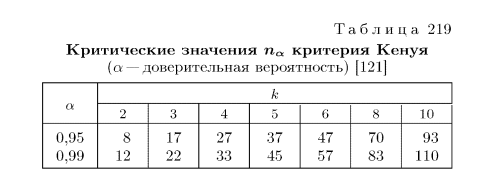

Просуммируем число $y < \max{y_{\min{}}} $ и  $y > \min{y_{\max{}}} $ 

In [ ]:
S = sum(np.ones(SIZE)[y1<max(y2min)]) + sum(np.ones(SIZE)[y1>min(y2max)])
S

In [ ]:
S > 110  # корреляция есть

## Критерий Стюарта



делим на 3 группы и сравниваем 1 и 3


In [ ]:
x1 = x[::3]
y1 = y[::3]

x1 = np.argsort(x1)
y1 = y1[x1]
SIZE1  =len(x1)

In [ ]:
M = SIZE1 // 3

In [ ]:
M

In [ ]:
y2 = [y1[m*M: m*M+M]  for m in range(groups_K) ]

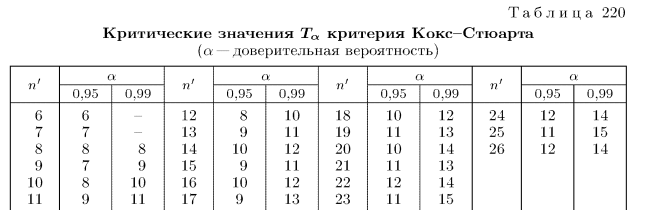

In [ ]:
S = abs(sum(np.ones(M)[y2[0]>y2[2]]) - sum(np.ones(M)[y2[0]<y2[2]]) ) 
S

In [ ]:
S  > 14

корреляция между интенсивностью движения по полосам **присутствует**

# Регрессионный анализ.

Линейные методы предполагают, что между признаками объекта и целевой переменной существует линейная зависимость, то есть:
$$ y = w_1 x_1 + b,$$
где у - целевая переменная (что мы хотим предсказать), $x_i$ -- признак объекта х, $w_i$ -- вес i-го признака, b -- bias (смещение, свободный член)

Часто предполагают, что объект х содержит в себе фиктивный признак, который всегда равен 1, тогда bias это есть вес этого признака. В этом случае формула принимает простой вид:
$$ y = <w, x>. $$

В матричной форме, в случае, когда у нас есть n объектов формулу можно переписать следующим образом:
$$ Y = Xw,$$
Y -- вектор размера n, X -- матрица, содержащая объекты-признаки размера $n \times k$, w -- вектор весов размера k.

Решение по методу наименьших квадратов дает 
$$ w = (X^TX)^{-1}X^TY $$

In [ ]:
x_train= x[:-10]
y_train= y[:-10]


x_test= x[-10:]
y_test= y[-10:]

In [ ]:
plt.figure(figsize=(10, 5))
# plt.plot(X_train, y_real, label='real') #линейный график
plt.scatter(x, y, label='train') #точечный график
plt.legend(loc='best')
plt.show()

x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train) # обучение модели
w=model.coef_
b=model.intercept_

In [ ]:
w, b

In [ ]:
y_pred=model.predict(x_train)

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, label='train',color = (0,0,0)) #точечный график
plt.plot(x_train,y_pred, label='predicted',color = (1,0,0))
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [ ]:
y_train_predicted = model.predict(x_train)
y_test_predicted = model.predict(x_test)

print('Train MSE: ', mean_squared_error(y_train, y_train_predicted))
print('Test MSE: ', mean_squared_error(y_test, y_test_predicted))

print('Train MAE: ', mean_absolute_error(y_train, y_train_predicted))
print('Test MAE: ', mean_absolute_error(y_test, y_test_predicted))


print('Train ',model.score(x_train, y_train) )
print('Test ', model.score(x_test, y_test))